# Long Method Heuristics

* df - pandas DataFrame containing the whole dataset
* df_train - pandas DataFrame containing the training set (approximately 80% of the dataset, selected by stratified sampling)
* d_test - pandas DataFrame containing the test set (approximately 20% of the dataset, selected by stratified sampling)

In [1]:
#load dataset
import pandas as pd
from sklearn.metrics import classification_report
import os

df = pd.read_excel("../Data/Long_Method_code_metrics_values.xlsx")
new_labels = {"label":     {"critical": 1, "major": 1, "minor": 1, "none": 0}}
df= df.replace(new_labels)

df_train = df[df['parts']=='train']
y_train = df_train['label']
df_test = df[df['parts']=='test']
y_test = df_test['label']

print("The first 5 rows of the training dataframe:\n", df_train.head())
print("*****************************************************************")
print("The labels of the first 5 lines of the training dataframe:\n", y_train.head())
print("*****************************************************************")
print("The first 5 rows of the testing dataframe:\n", df_test.head())
print("*****************************************************************")
print("The labels of the first 5 lines of the testing dataframe:\n", y_test.head())

The first 5 rows of the training dataframe:
    parts  label  sample_id  constructor  cbo  wmc  rfc  loc  returnsQty  \
0  train      0    3698602            0    4    1    0    3           1   
1  train      0    3698665            0    5    1    2    4           1   
2  train      0    3698860            0    0    1    0    3           1   
3  train      0    3699227            0    0    1    0    3           1   
4  train      0    3699521            0    1    1    1    8           1   

   variablesQty  ...  numbersQty  assignmentsQty  mathOperationsQty  \
0             0  ...           0               0                  0   
1             0  ...           0               0                  0   
2             0  ...           0               0                  2   
3             0  ...           0               0                  0   
4             1  ...           0               4                  0   

   maxNestedBlocksQty  anonymousClassesQty  lambdasQty  uniqueWordsQty  \
0  

In [2]:
print("Number of examples:", df.shape[0])
print("Number of train examples:", df_train.shape[0], "; positive:", df_train[y_train==1].shape[0], "; negative: ", df_train[y_train==0].shape[0])
print("Number of test examples:", df_test.shape[0], "; positive:", df_test[y_test==1].shape[0], "; negative: ", df_test[y_test==0].shape[0])

Number of examples: 2408
Number of train examples: 1926 ; positive: 223 ; negative:  1703
Number of test examples: 482 ; positive: 54 ; negative:  428


LM_1 is from Fard et al. (2013): Long Method has many lines of code.

In [3]:
def LM_1(df):   
    df['LM_1'] = df['loc'] > 50
    df['LM_1'].replace({False:0, True:1},inplace=True)

LM_2 is from Souza et al. (2017): Long Method is huge, complex and has a high number of nested blocks.

In [4]:
def LM_2(df):
    df['LM_2'] = (df['loc'] > 30) & (df['wmc'] > 4) & (df['maxNestedBlocksQty'] > 3)
    df['LM_2'].replace({False:0, True:1},inplace=True)

LM_3 is from Liu et al. (2011): Long Method has many lines of code or is highly complex.

In [5]:
def LM_3(df):    
    df['LM_3'] = (df['loc'] > 50) | (df['wmc'] > 10)
    df['LM_3'].replace({False:0, True:1},inplace=True)

ALL – LM_1, LM_2, and LM_3

In [6]:
def all_heuristics(df):
    df['ALL'] = df['LM_1'] & df['LM_2'] & df['LM_3']

ANY – LM_1, LM_2, or LM_3

In [7]:
def any_heuristics(df):
    df['ANY'] = df['LM_1'] | df['LM_2'] | df['LM_3']

Precision, recall, and F1-measure of the minority (smell) class (denoted as 1).

In [8]:
from sklearn.metrics import confusion_matrix

def precision(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    return tp/(tp+fp)

def recall(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    return tp/(tp+fn)

def fmeasure(true, predicted):
    p = precision(true, predicted)
    r = recall(true, predicted)
    return 2*p*r/(p+r)

Weighted vote – the model calculates the probability of the code sample suffering from the smell as a weighted vote of the individual classifiers. We use the F1-measure achieved on the training set as the weight and apply the softmax function to normalize weights (so they sum to 1).

In [9]:
import numpy as np

#applies softmax for each sets of scores in input:x.
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def get_weights():
    true = df['label']
    heuristics = ['LM_1', 'LM_2', 'LM_3']
    weights = np.zeros(len(heuristics))
    for i in range(len(heuristics)):
        predicted = df[heuristics[i]]
        weights[i] = fmeasure(true, predicted)
    print("weights:", weights)
    return weights

def weighted_vote(df):
    pd.options.mode.chained_assignment = None  # default='warn'
    
    heuristic_fmeasures = get_weights()
    weights = softmax(heuristic_fmeasures) 
    df['Weighted_Vote_probability'] = df['LM_1']*weights[0] + df['LM_2']*weights[1] + df['LM_3']*weights[2]
    is_smell = df['Weighted_Vote_probability'] > 0.5
    print("is smell: ",is_smell)
    df['Weighted_Vote'] = 0
    df['Weighted_Vote'][is_smell] = 1
    print("Weighted Vote: ", df['Weighted_Vote'])

In [10]:
#applies all heuristics to the df DataFrame 
def apply_heuristics(df):
    LM_1(df)
    LM_2(df)
    LM_3(df)    
    all_heuristics(df)
    any_heuristics(df)
    weighted_vote(df)    

Part : "train", "test" or "all" Heuristic : GC_1, GC_2, ..., GC_8, ALL, ANY, Weighted_Vote

In [11]:
def eval_calculation(heuristic, part):
    if(part=="train"):        
        true = df_train['label']
        predicted = df_train[heuristic]
    elif(part=="test"):
        true = df_test['label']
        predicted = df_test[heuristic]
    elif(part=="all"):        
        true = df['label']
        predicted = df[heuristic]
        
    p = precision(true, predicted)
    r = recall(true, predicted)
    f = fmeasure(true, predicted)
    
    return p, r, f

Part : "train", "test" or "all"
Heuristic : LM_1, LM_2, LM_3, ALL, ANY, Weighted_Vote 

In [12]:
def print_result(heuristic, part):
    p, r, f = eval_calculation(heuristic, part)
    
    print("Heuristic", heuristic, "on", part, ":", "Precision: %.2f" % p, "; Recall: %.2f" % r, "; F-measure: %.2f"% f)

We show weights here to make sure that our code works.

In [13]:
apply_heuristics(df)
apply_heuristics(df_train)
apply_heuristics(df_test)

weights: [0.38968481 0.36206897 0.53132832]
is smell:  0       False
1       False
2       False
3       False
4       False
        ...  
2403    False
2404    False
2405    False
2406    False
2407    False
Name: Weighted_Vote_probability, Length: 2408, dtype: bool
Weighted Vote:  0       0
1       0
2       0
3       0
4       0
       ..
2403    0
2404    0
2405    0
2406    0
2407    0
Name: Weighted_Vote, Length: 2408, dtype: int64
weights: [0.38968481 0.36206897 0.53132832]
is smell:  0       False
1       False
2       False
3       False
4       False
        ...  
2402    False
2403    False
2404    False
2405    False
2406    False
Name: Weighted_Vote_probability, Length: 1926, dtype: bool
Weighted Vote:  0       0
1       0
2       0
3       0
4       0
       ..
2402    0
2403    0
2404    0
2405    0
2406    0
Name: Weighted_Vote, Length: 1926, dtype: int64
weights: [0.38968481 0.36206897 0.53132832]
is smell:  8       False
10      False
13      False
15      False
21   

Printing the performance of each heuristic:

In [14]:
print_result('ANY', 'train')
print_result('ANY', 'test')
print_result('ANY', 'all')

Heuristic ANY on train : Precision: 0.85 ; Recall: 0.47 ; F-measure: 0.61
Heuristic ANY on test : Precision: 0.86 ; Recall: 0.33 ; F-measure: 0.48
Heuristic ANY on all : Precision: 0.85 ; Recall: 0.44 ; F-measure: 0.58


In [15]:
print_result('Weighted_Vote', 'train')
print_result('Weighted_Vote', 'test')
print_result('Weighted_Vote', 'all')

Heuristic Weighted_Vote on train : Precision: 0.92 ; Recall: 0.31 ; F-measure: 0.46
Heuristic Weighted_Vote on test : Precision: 1.00 ; Recall: 0.26 ; F-measure: 0.41
Heuristic Weighted_Vote on all : Precision: 0.93 ; Recall: 0.30 ; F-measure: 0.45


In [16]:
print_result('ALL', 'train')
print_result('ALL', 'test')
print_result('ALL', 'all')

Heuristic ALL on train : Precision: 0.96 ; Recall: 0.11 ; F-measure: 0.20
Heuristic ALL on test : Precision: 1.00 ; Recall: 0.11 ; F-measure: 0.20
Heuristic ALL on all : Precision: 0.97 ; Recall: 0.11 ; F-measure: 0.20


In [17]:

print_result('LM_3', 'train')
print_result('LM_3', 'test')
print_result('LM_3', 'all')

Heuristic LM_3 on train : Precision: 0.86 ; Recall: 0.40 ; F-measure: 0.55
Heuristic LM_3 on test : Precision: 0.89 ; Recall: 0.31 ; F-measure: 0.47
Heuristic LM_3 on all : Precision: 0.87 ; Recall: 0.38 ; F-measure: 0.53


In [18]:

print_result('LM_2', 'train')
print_result('LM_2', 'test')
print_result('LM_2', 'all')

Heuristic LM_2 on train : Precision: 0.88 ; Recall: 0.24 ; F-measure: 0.37
Heuristic LM_2 on test : Precision: 0.91 ; Recall: 0.19 ; F-measure: 0.31
Heuristic LM_2 on all : Precision: 0.89 ; Recall: 0.23 ; F-measure: 0.36


In [19]:

print_result('LM_1', 'train')
print_result('LM_1', 'test')
print_result('LM_1', 'all')

Heuristic LM_1 on train : Precision: 0.93 ; Recall: 0.26 ; F-measure: 0.40
Heuristic LM_1 on test : Precision: 1.00 ; Recall: 0.20 ; F-measure: 0.34
Heuristic LM_1 on all : Precision: 0.94 ; Recall: 0.25 ; F-measure: 0.39


Result of Table 6:

In [20]:
def result(index, data):
    rule = ['MLOC > 50', 'MLOC > 30 & VG > 4 & NBD > 3', 'MLOC > 50 | VG > 10', 'ALL', 'ANY', 'Weighted Vote']
    trainP = []
    trainR = []
    trainF = []
    testP = []
    testR = []
    testF = []
    allP = []
    allR = []
    allF = []
    for i in range(len(index)):
        p1, r1, f1 = eval_calculation(index[i], 'train')
        trainP.append(round(p1,2))
        trainR.append(round(r1,2))
        trainF.append(round(f1,2))
        
        p2, r2, f2 = eval_calculation(index[i], 'test')
        testP.append(round(p2,2))
        testR.append(round(r2,2))
        testF.append(round(f2,2))
        
        p3, r3, f3 = eval_calculation(index[i], 'all')
        allP.append(round(p3,2))
        allR.append(round(r3,2))
        allF.append(round(f3,2))
        
        p1 = p2 = p3 = r1 = r2 = r3 = f1 = f2 = f3 = 0
        
    data['Rule specification'] = rule
    data['Training set-P'] = trainP
    data['Training set-R'] = trainR
    data['Training set-F'] = trainF
    data['Test set-P'] = testP
    data['Test set-R'] = testR
    data['Test set-F'] = testF
    data['All-P'] = allP
    data['All-R'] = allR
    data['All-F'] = allF
    
    df = pd.DataFrame(data,index)
    
    return df

Show dataframe:

In [21]:
index = ['LM_1','LM_2','LM_3','ALL','ANY','Weighted_Vote']
data = {'Rule specification':[], 'Training set-P':[], 'Training set-R':[], 'Training set-F':[], 
        'Test set-P':[], 'Test set-R':[], 'Test set-F':[], 
        'All-P':[], 'All-R':[], 'All-F':[]}
df = result(index, data)
df
#print(df)

,Rule specification,Training set-P,Training set-R,Training set-F,Test set-P,Test set-R,Test set-F,All-P,All-R,All-F
LM_1,MLOC > 50,0.93,0.26,0.40,1.00,0.20,0.34,0.94,0.25,0.39
LM_2,MLOC > 30 & VG > 4 & NBD > 3,0.88,0.24,0.37,0.91,0.19,0.31,0.89,0.23,0.36
LM_3,MLOC > 50 | VG > 10,0.86,0.40,0.55,0.89,0.31,0.47,0.87,0.38,0.53
ALL,ALL,0.96,0.11,0.20,1.00,0.11,0.20,0.97,0.11,0.20
ANY,ANY,0.85,0.47,0.61,0.86,0.33,0.48,0.85,0.44,0.58
Weighted_Vote,Weighted Vote,0.92,0.31,0.46,1.00,0.26,0.41,0.93,0.30,0.45


Change dataframe to csv format and save it:

In [22]:
import os
df.to_csv(os.path.join('../Outputs/Tables','Long_Method_Table_6.csv'))

Visualization:

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualization():
    barWidth = 0.25
    fig = plt.figure(figsize=(12, 8))
    preci = []
    rec = []
    fmeas = []
    heuristics = []
    df2 = df[['Test set-P', 'Test set-R', 'Test set-F']]
    df_visual = df2.sort_values('Test set-F')
    
    preci = df_visual['Test set-P']
    rec = df_visual['Test set-R']
    fmeas = df_visual['Test set-F']
    heuristics = df_visual.index
        
    br1 = np.arange(len(preci))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    
    plt.bar(br1, preci, color = 'b', width = barWidth, label = 'Precision')
    plt.bar(br2, rec, color = 'g', width = barWidth, label = 'Recall')
    plt.bar(br3, fmeas, color = 'orange', width = barWidth, label = 'F-measure')
    
    plt.xlabel('Long Method Heuristics', fontweight = 'bold', fontsize = 15)
    plt.ylabel('Values', fontweight = 'bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(preci))],heuristics)
    
    plt.legend()
    plt.show()
    
    fig.savefig('../Outputs/Figures/Heuristic_based_approaches_Long_Method_test_set_Fig_5.png', dpi=fig.dpi)
    
    plt.close()
    

Fig 5:

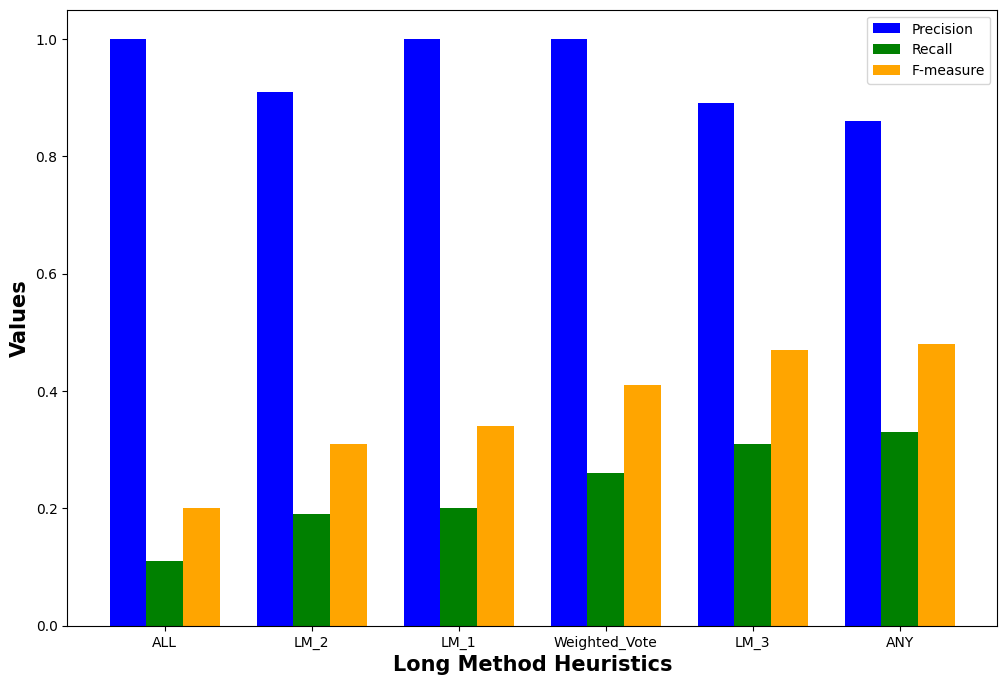

In [24]:
visualization()